In [1]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset
from torchvision import transforms


class FaceMaskDataset(Dataset):
    def __init__(self, root_dir, split='train', test_size=0.2, image_size=224, random_seed=42):
        self.root_dir = root_dir
        self.image_size = image_size
        self.split = split

        if not os.path.exists(self.root_dir):
            raise RuntimeError(f"Dataset not found at {self.root_dir}.")

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        self.data = []
        self.labels = []
        self.class_names = sorted(os.listdir(self.root_dir))  # ['with_mask', 'without_mask']

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

        # Split dataset
        train_data, test_data, train_labels, test_labels = train_test_split(
            self.data, self.labels, test_size=test_size, stratify=self.labels, random_state=random_seed
        )

        if self.split == 'train':
            self.data = train_data
            self.labels = train_labels
        else:
            self.data = test_data
            self.labels = test_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

In [3]:
class ModelCNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size =5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride = 2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        print(x.size())
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [4]:
from torchvision.models import resnet18, ResNet18_Weights

batch_size = 32
num_classes = 2
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
train_dataset = FaceMaskDataset(root_dir='/kaggle/input/face-mask-dataset/data', split='train')
test_dataset = FaceMaskDataset(root_dir='/kaggle/input/face-mask-dataset/data', split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained ResNet18 dan ubah output layer
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

# Optimizer dan Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Cek jumlah parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing"):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    avg_train_loss = train_loss / len(train_dataset)
    avg_test_loss = test_loss / len(test_dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


Total parameters: 11.18M
Trainable parameters: 11.18M


Epoch 1/25 - Training:  43%|████▎     | 82/189 [00:24<00:31,  3.43it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/25 - Testing: 100%|██████████| 48/48 [00:11<00:00,  4.08it/s]


Epoch 1: Train Loss 0.0436, Test Loss 0.0170, Test Acc 0.9967


Epoch 2/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.50it/s]


Epoch 2: Train Loss 0.0054, Test Loss 0.0101, Test Acc 0.9974


Epoch 3/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.38it/s]


Epoch 3: Train Loss 0.0041, Test Loss 0.0240, Test Acc 0.9914


Epoch 4/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.55it/s]


Epoch 4: Train Loss 0.0048, Test Loss 0.0180, Test Acc 0.9960


Epoch 5/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.39it/s]


Epoch 5: Train Loss 0.0022, Test Loss 0.0108, Test Acc 0.9980


Epoch 6/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.37it/s]


Epoch 6: Train Loss 0.0004, Test Loss 0.0116, Test Acc 0.9967


Epoch 7/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.70it/s]


Epoch 7: Train Loss 0.0002, Test Loss 0.0131, Test Acc 0.9967


Epoch 8/25 - Testing: 100%|██████████| 48/48 [00:07<00:00,  6.79it/s]


Epoch 8: Train Loss 0.0002, Test Loss 0.0144, Test Acc 0.9967


Epoch 9/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.13it/s]


Epoch 9: Train Loss 0.0005, Test Loss 0.0173, Test Acc 0.9954


Epoch 10/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.18it/s]


Epoch 10: Train Loss 0.0124, Test Loss 0.0234, Test Acc 0.9954


Epoch 11/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.23it/s]


Epoch 11: Train Loss 0.0084, Test Loss 0.0182, Test Acc 0.9960


Epoch 12/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]


Epoch 12: Train Loss 0.0050, Test Loss 0.0223, Test Acc 0.9960


Epoch 13/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.52it/s]


Epoch 13: Train Loss 0.0025, Test Loss 0.0169, Test Acc 0.9954


Epoch 14/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Epoch 14: Train Loss 0.0003, Test Loss 0.0171, Test Acc 0.9954


Epoch 15/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.09it/s]


Epoch 15: Train Loss 0.0002, Test Loss 0.0173, Test Acc 0.9967


Epoch 16/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.59it/s]


Epoch 16: Train Loss 0.0001, Test Loss 0.0177, Test Acc 0.9967


Epoch 17/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.34it/s]


Epoch 17: Train Loss 0.0001, Test Loss 0.0174, Test Acc 0.9974


Epoch 18/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.33it/s]


Epoch 18: Train Loss 0.0000, Test Loss 0.0177, Test Acc 0.9967


Epoch 19/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.24it/s]


Epoch 19: Train Loss 0.0003, Test Loss 0.0140, Test Acc 0.9974


Epoch 20/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.36it/s]


Epoch 20: Train Loss 0.0000, Test Loss 0.0122, Test Acc 0.9967


Epoch 21/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.53it/s]


Epoch 21: Train Loss 0.0001, Test Loss 0.0182, Test Acc 0.9980


Epoch 22/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.55it/s]


Epoch 22: Train Loss 0.0001, Test Loss 0.0169, Test Acc 0.9974


Epoch 23/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.16it/s]


Epoch 23: Train Loss 0.0000, Test Loss 0.0160, Test Acc 0.9967


Epoch 24/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.31it/s]


Epoch 24: Train Loss 0.0000, Test Loss 0.0160, Test Acc 0.9974


Epoch 25/25 - Testing: 100%|██████████| 48/48 [00:06<00:00,  7.71it/s]

Epoch 25: Train Loss 0.0000, Test Loss 0.0155, Test Acc 0.9974


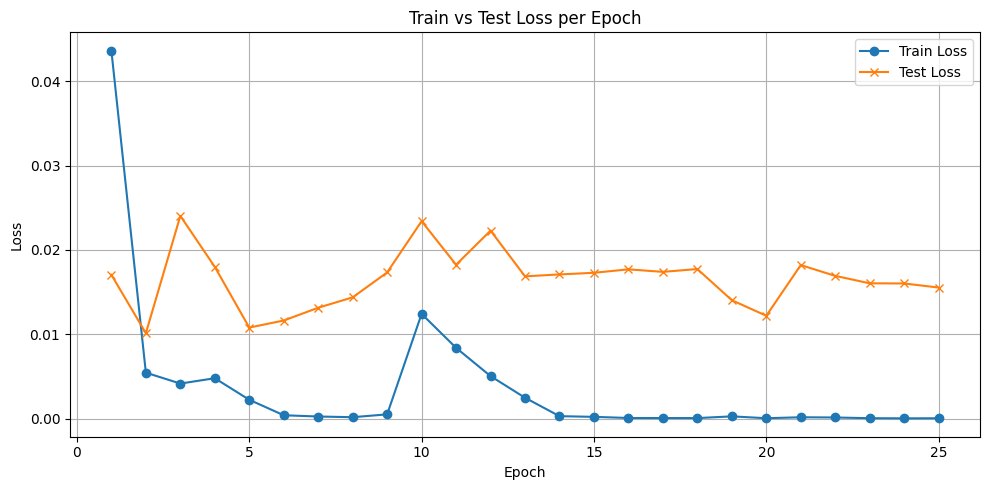

In [5]:

# Save model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'face_mask_checkpoint.pth')

# Plot loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()